# Generating Haikus From Images

### Installing Libraries

In [1]:
#pip install syllapy

In [2]:
#pip install transformers

In [3]:
#pip install random_word

In [4]:
#pip install nltk==3.5

In [5]:
#!pip install git+https://github.com/openai/CLIP.git

### Import Libraries

In [6]:
#libraries for importing images
import torchvision.models as models
import torchvision.transforms as transforms
import json
from PIL import Image
import torch
import transformers
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel

#libraries for generating poems
from transformers import pipeline, set_seed
import nltk
nltk.download("stopwords")
set_seed(42)
import random
import re
import syllapy
from nltk.corpus import stopwords
first_words = set(stopwords.words('english'))
first_words = list(first_words - set(("ain","am","an","and","aren","aren't","at","be","been","being","between","both","by","couldn","couldn't","d","doesn","doesn't","doing","don","don't","down","during","further","hadn","hadn't","hasn","hasn't","haven","haven't",\
                            "he","her","here","hers","herself","him","himself","i","isn","isn't","it","it's","its","itself","ll","m","ma","me","mightn","mightn't","mustn","mustn't","myself","needn","needn't","not","not","o","of","off","on","once",\
                            "or","other","ours","ourselves","out","over","own","re","s","same","shan","shan't","she","she's","shuld've","shouldn","shouldn't","t","than","that'll","theirs","them","themselves","there","these","they","those","through",\
                            "too","up","ve","very","was","wasn","wasn't","we","were","weren","weren't","who","whom","won","won't","wouldn","wouldn't","y","you","you'd","you'll","you're","you've","yours","yourself","yourselves","didn","didn't","did","should've")))
from random_word import RandomWords
r = RandomWords()
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

#libraries for using clip 
import pandas as pd
import numpy as np
import torch
import clip
from PIL import Image
from IPython.display import Image as im
import os
from torchvision.datasets import CIFAR100
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from tqdm import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matthewstreichler/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/matthewstreichler/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Uploading image as base content of haiku

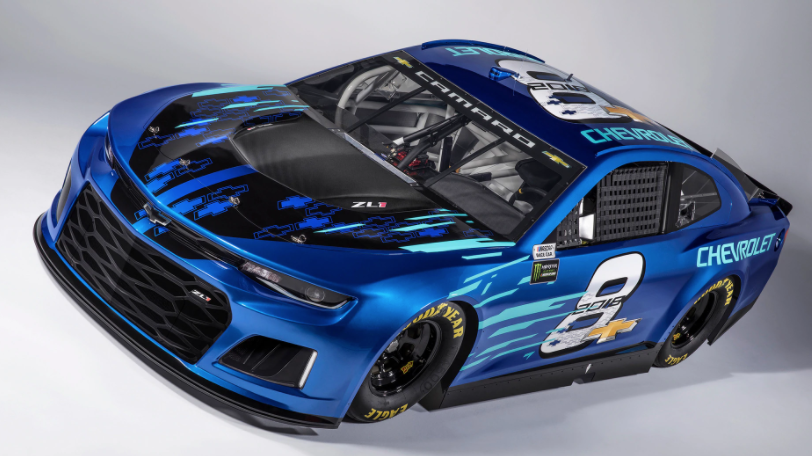

In [18]:
img = Image.open('racecar.png').convert('RGB'); img #input image

In [19]:
vgg16 = models.vgg16(pretrained = True)

In [20]:
transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor()])
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
img_2 = normalize(transform(img))
img_2 = img_2.unsqueeze(0)
prediction = vgg16(img_2)
prediction.data.numpy().argmax()

#download labels: 
labels = json.load(open('imagenet_class_index.json'))
input = labels[str(prediction.data.numpy().argmax())][1]
input = re.sub('_',' ',input)

In [21]:
labels

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

### Generating Haiku

In [22]:
def gen_story(beginning_line,sub_first=False):
    '''
    given the first few words, will generate a dramatic sentence.
    If sub_first = True, will return the sentence not containing the begininning_lines fed it
    '''
    
    story_gen = pipeline('text-generation', model="pranavpsv/gpt2-genre-story-generator")
    beginning_line = "<BOS> <drama>" + ' ' + beginning_line
    results = story_gen(beginning_line)
    for text in results:
        output = str(text.values())[14:-3].lower()
        if sub_first == True:
            output = re.sub(beginning_line.lower(),'',output)
        output = re.sub( "<bos> <drama>",'',output)
        output = re.sub('[\n]','',output) #removing \n
        output = re.sub(r"[^\w\s']",' ',output) #removing other punctuation
        output = re.sub(r'[\d]','', output) #removing numbers
        output = re.sub(' +',' ',output) #removing double spaces
       
    return output

def syllable_counter(sentence,max,last_line = False):
    '''
    function takes original sentence and returns sentence
    with max specified number of syllables
    '''
    
    count = 0
    line= ''
    
    # counts syllables in sentence and adds word to line if syllable is less than max,
    # if syllable = max, then breaks
    for word in sentence.split():
        new_count = syllapy.count(word)
        if count + new_count <= max:
            count += new_count
            line = line + word + ' '
     
        else:
            break
 
    nouns = {x.name().split('.', 1)[0] for x in wordnet.all_synsets('n')}
  
    # adding in "stop word" to increment syllable count by one
    # if next word in actual sentence is more than one syllable
    if last_line == False: 
        while count < max:
            additional_words = ['life','need','heart']
            new_word = random.choice(additional_words)
            count += 1
            line += new_word
  
    else: #if last line = true, indicates we may need to end sentence with a noun
          # if syllable count is short
  
        if count == (max - 2):
        
            #If we need 2 more syllabes, use the wordnet package to check
            # for synonyms and antonyms for the last word that was over count. 
            synonyms = []
            antonyms = []
            confirmed = 0

            # This nested for loop creates lists of both synonyms and antonyms
            # for the last word
            for syn in wordnet.synsets(word):
                for l in syn.lemmas():
                    synonyms.append(l.name())
                    if l.antonyms():
                        antonyms.append(l.antonyms()[0].name())
       
      
                # While loop first checks if there are any synonyms or antonyms 
                # for the final word that are under two syllables.
                # If so, it ends the loop. 
                while confirmed == 0:
                    for i in synonyms:
                        if syllapy.count(i)==2 and i in nouns:
                            additional_noun = i
                            line += additional_noun
                            confirmed = confirmed+1
                            break
                    for i in antonyms:
                        if syllapy.count(i)==2 and i in nouns:
                            additional_noun = i
                            line += additional_noun
                            confirmed = confirmed+1
                            break

                    # After going through the synonyms and antonyms,
                    # it uses the random word package.
                    # It keeps generating nouns until there is one
                    # that meets the syllable requirement.
                    r = RandomWords()
                    b = r.get_random_word(hasDictionaryDef="true")
                    if syllapy.count(b)==2 and b in nouns:
                        additional_noun = b
                        line += additional_noun
                        confirmed = confirmed + 1

        elif count == (max - 3):

            synonyms = []
            antonyms = []
            confirmed = 0

            for syn in wordnet.synsets(word):
                for l in syn.lemmas():
                    synonyms.append(l.name())
                    if l.antonyms():
                        antonyms.append(l.antonyms()[0].name())
     
                while confirmed == 0:
                    for i in synonyms:
                        if syllapy.count(i)==3 and i in nouns:
                            additional_noun = i
                            line += additional_noun
                            confirmed = confirmed+1
                            break
                    for i in antonyms:
                        if syllapy.count(i)==3 and i in nouns:
                            additional_noun = i
                            line += additional_noun
                            confirmed = confirmed+1
                            break
                    r = RandomWords()
                    b = r.get_random_word(hasDictionaryDef="true", includePartOfSpeech="noun")
                    if syllapy.count(b)==3 and b in nouns:
                        additional_noun = b
                        line += additional_noun
                        confirmed = confirmed + 1
  
        elif count == (max - 1):
        
            synonyms = []
            antonyms = []
            confirmed = 0

            for syn in wordnet.synsets(word):
                for l in syn.lemmas():
                    synonyms.append(l.name())
                    if l.antonyms():
                        antonyms.append(l.antonyms()[0].name())
       
                while confirmed == 0:
                    for i in synonyms:
                        if syllapy.count(i)==1 and i in nouns:
                            additional_noun = i
                            line += additional_noun
                            confirmed = confirmed+1
                            break
                    for i in antonyms:
                        if syllapy.count(i)==1 and i in nouns:
                            additional_noun = i
                            line += additional_noun
                            confirmed = confirmed+1
                            break
                    r = RandomWords()
                    b = r.get_random_word(hasDictionaryDef="true", includePartOfSpeech="noun")
                    if syllapy.count(b)==1 and b in nouns:
                        additional_noun = b
                        line += additional_noun
                        confirmed = confirmed + 1
  
    return line

def gen_poem2(label):
    poem = []
    label = re.sub('_',' ',label)
    first_word = random.choice(first_words) + ' ' + label
    sentence = gen_story(first_word, False)

    first_line = syllable_counter(sentence,5)

    poem.append(first_line)

    second_line = gen_story(first_line, True)

    second_line = syllable_counter(second_line,7)
    poem.append(second_line)
  
    total = first_line + ' ' + second_line
    third_line = gen_story(total, True)
    third_line = syllable_counter(third_line,5,last_line = True)
    poem.append(third_line)

    haiku = ''
    for i in poem:
        haiku += i 

    return haiku

In [23]:
list_haikus = []
for i in range(10):
    haiku = gen_poem2(input)
    list_haikus.append(haiku)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

### Connecting with CLIP

In [24]:
list_haikus

['against racer in ical competition the ical racer wins ',
 'that racer is a iglancity in the lifeof a biker the ',
 "few racer lifeheartteen angst fans are aware of it's tom conway dolph ",
 'where racer dave john ich is living with his wife ich is looking for ',
 'that racer racer g f larry haines is so good in the race',
 'should racer race the racer should be the racer for the two booster',
 'such racer johnny of a racing car a rich woman a lute in ',
 'are racer teams in ive ever since they lost it ive ever since ive ',
 'while racer racing during his first race he wins on the lap of the ',
 "just racer the film's just as it starts at the heartof the story the "]

In [25]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Prepare the inputs
image = img
image_input = preprocess(image).unsqueeze(0).to(device)
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in list_haikus]).to(device)


# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# Pick the most similar label for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(1)

# Print the result
print("\nTop prediction:\n")
for value, index in zip(values, indices):
    print(f"{list_haikus[index]}: {100 * value.item():.2f}%")
    label = list_haikus[index]
    percent = value.item()


Top prediction:

such racer johnny of a racing car a rich woman a lute in : 43.41%
